<a href="https://colab.research.google.com/github/adrigrillo/dl/blob/master/assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Course 2019
## Assignment 1:

Download the Iris data and explore it, (visualize it, how many classes, 
instances, features, etc.. Select feature number 0 and 2 and the first
100 samples and do the following analysis: 

1. Implement the logistic regression model that discussed in the class (with and
without regularization... Use Gradient descent algorithm for updating the parameters.
Plot the results.

2. Explore the influence of learning rate on the convergence of the model.
Tune the learning rate.

3. Repeat steps 1-4 for different randomly selected features (e.g. 1 and 3 or 2 
and 3. and compare the results.

4. Give the option to the users to select whatever combination of features they
want and your code will do the rest.

5.  Try your model on Monk2 dataset and report the results, (test accuracy, 
training accuracy, optimal learning rate, loss value.. Use the last 20% of the
data as test.


In [3]:
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


Download the dataset and explore the content. The features 0 and 2 will be used.
The dataset contains three different classes:

- Iris-setosa
- Iris-versicolor
- Iris-virginica


In [4]:
from sklearn import preprocessing
df = pd.read_csv('./iris.data', header=None)
df.head()


,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


Describe the dataset


In [5]:
df.describe()


,0,1,2,3
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


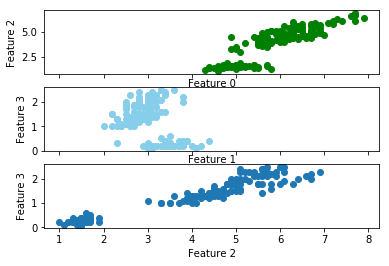

In [6]:
x1=df.loc[:,0]
y1=df.loc[:,2]

x2=df.loc[:,1]
y2=df.loc[:,3]

x3=df.loc[:,2]
y3=df.loc[:,3]

fig, axs = plt.subplots(3, 1, sharex='all')

# Plot each graph, and manually set the y tick values
axs[0].plot(x1, y1, 'o', color='g')
axs[0].set_ylabel('Feature 2')
axs[0].set_xlabel('Feature 0')

axs[1].plot(x2, y2, 'o',color='skyblue')
axs[1].set_ylabel('Feature 3')
axs[1].set_xlabel('Feature 1')

axs[2].plot(x3, y3,'o')
axs[2].set_ylabel('Feature 3')
axs[2].set_xlabel('Feature 2')

plt.show()


## Part 1.
Implement the logistic regression model that discussed in the class
(with and without regularization). Use Gradient descent algorithm
for updating the parameters. Plot the results.

First, we are going to create the dataset that we are going to use
in this part. It will generated using the features number 0 and 2 with
the objective of predicting the output class. 


In [19]:
def generate_data_with_features(data: pd.DataFrame, features: List[int], elements: int = 100,
                                normalise: bool = False, randomize: bool = False) -> pd.DataFrame:
    """
    Method to obtain a dataset with the features and the size desired. This
    methods uses sampling without replacement to obtain the elements.

    The indices are reset to make the sample independent of the previous dataset.
    Normalisation are made in column by column style, using only numeric columns.

    :param data: dataframe with the original data
    :param features: list with the column name of the features
    :param elements: number of elements
    :param normalise: flag to normalise the data
    :param randomize: flag to randomise the selection
    :return: dataframe with the new data with the desired characteristics
    """
    if randomize is False:
        data = data[features][:elements].reset_index(drop=True)
    else:
        data = data[features].sample(elements, random_state=47).reset_index(drop=True)
    if normalise:
        for i in features:
            column = data[i].values.reshape(-1, 1)
            if column.dtype == np.float64 or column.dtype == np.int64:
                min_max_scaler = preprocessing.MinMaxScaler()
                scaled_column = min_max_scaler.fit_transform(column)
                data[i] = scaled_column.reshape(-1)
    return data

NameError: name 'List' is not defined

In [8]:
#Define input
x=df[[0,2]].loc[:100].T
x.head()


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,5.1,4.9,4.7,4.6,5.0,5.4,4.6,5.0,4.4,4.9,...,6.1,5.8,5.0,5.6,5.7,5.7,6.2,5.1,5.7,6.3
2,1.4,1.4,1.3,1.5,1.4,1.7,1.4,1.5,1.4,1.5,...,4.6,4.0,3.3,4.2,4.2,4.2,4.3,3.0,4.1,6.0


In [9]:

#Normalize it
x1=x.loc[0]
x2=x.loc[2]
normalized_X1 = pd.DataFrame(preprocessing.normalize([x1]))
normalized_X2 = pd.DataFrame(preprocessing.normalize([x2]))

x = pd.concat([normalized_X1, normalized_X2])

In [10]:
#Initialize the weights
w= np.random.rand(2) #Size (2,1)
print(w.shape)

#Product of input and weights
z= np.dot(w.T, x) #size(101)
print(z)
sigma=1/(1+np.exp(-z)) 
print(sigma.shape)

#Output
y=np.unique(df[4].loc[:100], return_inverse=True)[1]
print(y.shape)

(2,)
[0.08637123 0.08435847 0.07984244 0.08384262 0.08536485 0.09690021
 0.08133934 0.08786813 0.07932658 0.08686176 0.09189365 0.08835866
 0.0833521  0.07081036 0.08840931 0.09491278 0.08688708 0.08637123
 0.09991934 0.08887451 0.09690021 0.08887451 0.07132621 0.09388108
 0.09586851 0.09037142 0.09037142 0.08988089 0.08737761 0.08735228
 0.08835866 0.09189365 0.08988089 0.09039674 0.08686176 0.08035829
 0.08789346 0.08686176 0.0768233  0.08887451 0.08286157 0.07782968
 0.0768233  0.09037142 0.09888764 0.0833521  0.09137779 0.08133934
 0.09088727 0.08536485 0.18810072 0.17705589 0.1921009  0.15548207
 0.18056555 0.17001124 0.18105607 0.13192083 0.18157192 0.14995966
 0.13793377 0.16451415 0.16051396 0.17904332 0.14647532 0.17757174
 0.16900486 0.16100449 0.17504313 0.15398517 0.17953384 0.16152034
 0.18606264 0.17904332 0.17204932 0.17656536 0.18859124 0.19259143
 0.17303037 0.14497842 0.15047551 0.14797223 0.15599793 0.18805007
 0.1669921  0.17303037 0.18508158 0.17354623 0.15899173 0

In [0]:
#Cost function

J=np.sum(-y*np.log(sigma)-(1-y)*np.log(1-sigma))/len(sigma)
J

0.6858422243149137

In [0]:
# Learning
alpha=0.9

for i in range(0,1000):
    w=w+alpha*np.dot(y-sigma,x.T)/len(sigma)
    
    #Product of input and weights
    z= np.dot(w.T, x)
    sigma=1/(1+np.exp(-z))
    J=np.sum(-y*np.log(sigma)-(1-y)*np.log(1-sigma))/len(sigma)
    print(J)

0.6357130787121555
0.6354871076294939
0.6352618689127723
0.635037356618953
0.6348135648574699
0.6345904877897551
0.6343681196287727
0.6341464546385539
0.6339254871337369
0.6337052114791115
0.6334856220891683
0.6332667134276496
0.6330484800071073
0.6328309163884615
0.632614017180566
0.6323977770397758
0.6321821906695195
0.6319672528198745
0.6317529582871468
0.6315393019134544
0.6313262785863138
0.6311138832382319
0.6309021108462991
0.6306909564317877
0.630480415059754
0.6302704818386438
0.6300611519198994
0.6298524204975736
0.6296442828079452
0.6294367341291377
0.6292297697807422
0.629023385123443
0.6288175755586484
0.6286123365281218
0.6284076635136187
0.6282035520365261
0.627999997657505
0.6277969959761355
0.6275945426305674
0.6273926332971709
0.6271912636901933
0.6269904295614167
0.6267901266998194
0.6265903509312415
0.6263910981180519
0.6261923641588194
0.6259941449879861
0.6257964365755443
0.625599234926716
0.625402536081636
0.6252063361150361
0.6250106311359348
0.6248154172873275


0.539209864040388
0.5390916774600257
0.5389735287719821
0.5388554179399422
0.5387373449277887
0.5386193096996013
0.5385013122196551
0.5383833524524188
0.5382654303625534
0.538147545914911
0.5380296990745325
0.5379118898066473
0.5377941180766703
0.5376763838502026
0.5375586870930277
0.537441027771112
0.5373234058506022
0.5372058212978249
0.5370882740792838
0.53697076416166
0.5368532915118095
0.536735856096762
0.5366184578837201
0.5365010968400574
0.5363837729333175
0.5362664861312126
0.536149236401622
0.5360320237125915
0.5359148480323309
0.5357977093292143
0.5356806075717775
0.5355635427287172
0.5354465147688903
0.5353295236613116
0.5352125693751537
0.535095651879745
0.534978771144569
0.534861927139263
0.5347451198336163
0.5346283491975699
0.5345116152012152
0.5343949178147919
0.5342782570086888
0.5341616327534403
0.534045045019727
0.5339284937783741
0.5338119790003499
0.5336955006567655
0.5335790587188727
0.5334626531580636
0.5333462839458698
0.5332299510539601
0.5331136544541412
0.53

Creo que se necesita un regularization para recudir el coste más rápido D: